<a href="https://colab.research.google.com/github/LeilaMemoi/Deep_learning/blob/main/Deep_Learning_Project_Leila_Maritim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




<CENTER>
<font size="8"></br>SITS FOR CROP CLASSIFICATION</font></br></div>
</CENTER>
<CENTER>


<span style="color:blue">Student: Maritim Leila</span>
</CENTER>

</div>

#Introduction

SITS: Satellite image time series

These are a compilation of satellite images captured over an areas at distinct time intervals. The images are arranged in a three dimensional structure and each location in space and time(a pixel) corresponds to a vector of values observed across the timeline. This type of data for example is useful in classification of crop types by taking into account its phenologocial or growth variations over time.

The task at hand is a univariate time series classification. The goal is to assign a label to the entire sequence based on the temporal patterns in the bands.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from textwrap import dedent
import torch
import torch.nn as nn
from torch.utils.data import Dataset,TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from datetime import datetime
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn



import torchvision.models as models

In [ ]:
os.chdir("/content/drive/MyDrive/Time series classification-project/Project")

In [ ]:
#activating CUDA
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#Data exploration
miniTimeMatch is a modified version of TimeMatch with measurements are averaged over parcels. The original dataset covers four countires but for this study, we only consider Austria. It is a dataset made up 49168 time series with averaged reflectance valuesover the agricultural fields to obtain multivariate time series of 10 spectral bands(Sentinel 2 excluding bands 1,9, and 10)
 we average the reflectance values.Painblanc et al,(2023)

 Four classes were dropped to manage class imbalance and thus improve performance of the models. These classes had less than 100 samples.

In [ ]:

data = np.load(os.path.join('data_CDE', "data_AT1.npz"), allow_pickle=True)
series = data['series'] # time series (m,l,d) where m is the number of time series in a given domain,
## l is the length of the time series, and d is the number of channels in the image
labels = data['labels'] # label associated with each time series
dates = data['dates'] # acquisition dates (datetime package)
class_names = data['class_names'] # names of the class

In [ ]:
print(dedent(f'''
Dataset shapes and types:
    series: {series.shape,type(series)}
    labels: {labels.shape,type(labels)}
    dates: {dates.shape,type(dates)}
    class:{class_names.shape,type(class_names)}
'''))


Dataset shapes and types:
    series: ((49168, 58, 10), <class 'numpy.ndarray'>)
    labels: ((49168,), <class 'numpy.ndarray'>)
    dates: ((58,), <class 'numpy.ndarray'>)
    class:((17,), <class 'numpy.ndarray'>)



## class distribution

In [ ]:


#To visualize the distribution of classes
def classFrequency(labels,colormap,class_names,scale=True):
  unique_labels, label_counts = np.unique(labels, return_counts=True)

  #colormap
  cmap = plt.get_cmap(colormap)  #'tab20' for 17classes

  # Plotting class frequencies
  fig, ax = plt.subplots()
  if scale:
    bars = ax.bar(class_names, np.log(label_counts), color=[cmap(i) for i in range(len(class_names))])
  else:
    bars = ax.bar(class_names, label_counts, color=[cmap(i) for i in range(len(class_names))])


  legend_labels = [f'Class {label}: {class_name}' for label, class_name in zip(unique_labels, class_names)]
  ax.legend(bars, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
  plt.xlabel('Class ')
  plt.ylabel('Count(Log scale)')
  plt.title('Class Frequencies')

  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45, ha='right')

  plt.show()

In [ ]:
# Calculate class frequencies
import pandas as pd
def label_count(label, name):
    unique_labels, label_counts = np.unique(label, return_counts=True)
    counts_df = pd.DataFrame({'Class': unique_labels, f'Count_{name}': label_counts})
    return counts_df

counts_data = label_count(labels,'class_distribution')
print(counts_data)

    Class  Count_class_distribution
0       0                     10135
1       1                       460
2       2                     18231
3       3                       288
4       4                       588
5       5                        65
6       6                         5
7       7                         3
8       8                        20
9       9                        85
10     10                        31
11     11                      5150
12     12                      4629
13     15                      1026
14     16                       586
15     17                      1476
16     18                      6390


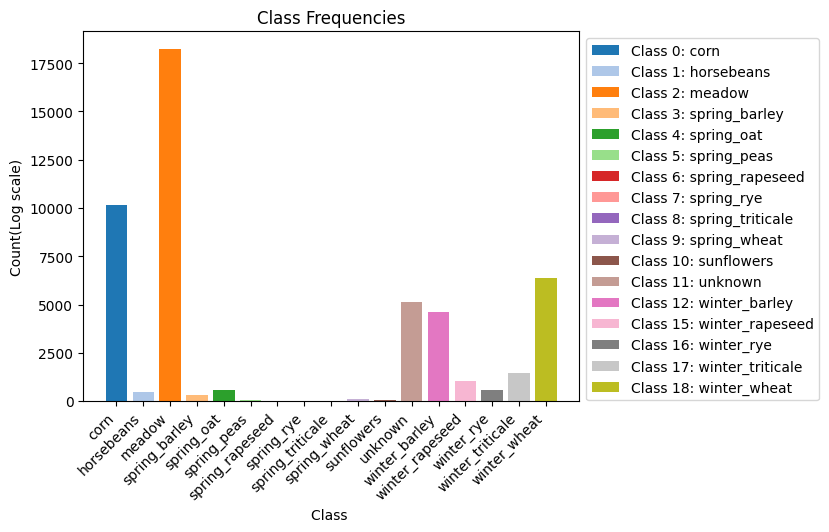

<Figure size 640x480 with 0 Axes>

In [ ]:
#in the whole dataset
classFrequency(labels,'tab20',class_names,scale=False)


plt.tight_layout()
plt.show()

The plot above (fig 1)shows class distribution in the dataset. We note some imbalance in class distribution. Five classes in particular, spring peas, spring rapeseed,spring rye,spring triticale,spring wheat and sunflowers have a much smaller count compared to the rest of the classes(less than 100). This would affect the splitting of the dataset as there might not be sufficient samples to have the data in each of the splits. Furthermore, the models may not perform well predicting these classes. Therfore, it is necessary to drop these classes.

For improved visualization, we use the log scale(fig 2)

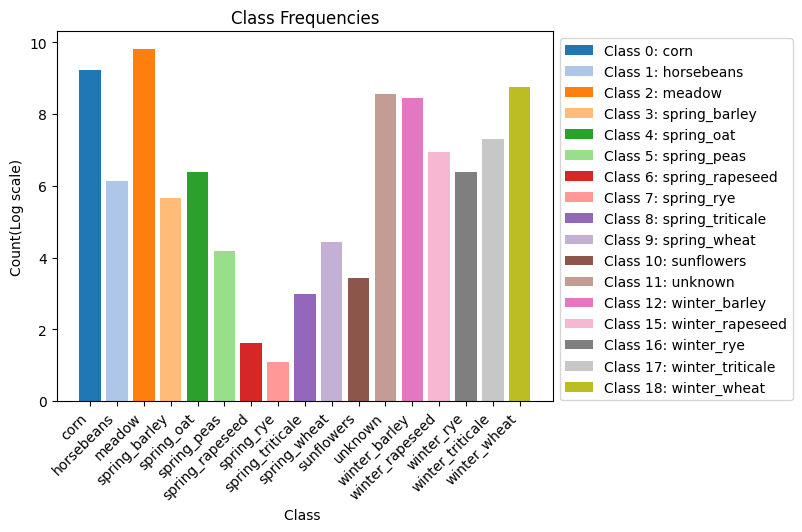

<Figure size 640x480 with 0 Axes>

In [ ]:
#in the whole dataset
classFrequency(labels,'tab20',class_names,scale=True)


plt.tight_layout()
plt.show()

### class drops

In [ ]:
import numpy as np
def class_drop(X,y):
  # Count the occurrences of each class in the training set
  unique_labels, class_counts = np.unique(y, return_counts=True)

  # Set a threshold for the minimum number of samples per class
  min_samples_per_class = 100

  # Find classes with fewer samples than the threshold
  classes_to_drop = np.where(class_counts < min_samples_per_class)[0]

  # Print the classes to be dropped
  print("Classes to be dropped:", classes_to_drop)

  # Filter out samples belonging to the identified classes from the data
  mask_train = np.isin(y, classes_to_drop, invert=True)


  X_filtered = X[mask_train]
  y_filtered = y[mask_train]

  return X_filtered,y_filtered

In [ ]:
X,y=class_drop(series,labels)


Classes to be dropped: [ 5  6  7  8  9 10]


In [ ]:
classes_to_drop = ['spring_peas','spring_rye', 'spring_rapeseed','spring_triticale','spring_wheat','sunflowers']

# Drop the specified classes
class_names_filtered = class_names[~np.isin(class_names, classes_to_drop)]
print(class_names_filtered)

['corn' 'horsebeans' 'meadow' 'spring_barley' 'spring_oat' 'unknown'
 'winter_barley' 'winter_rapeseed' 'winter_rye' 'winter_triticale'
 'winter_wheat']


With the dropped classes, we have to adjust the labels to have a consecutive order to avoid potential issues arising in subsequent algorithms and libraries and to also have a standard convention

In [ ]:
unique_labels = np.unique(y)

# Create a mapping from old labels to new consecutive labels
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

# Update labels using the mapping
y = np.array([label_mapping[label] for label in y])


In [ ]:
counts_data = label_count(y,'class_distribution')
print(counts_data)

    Class  Count_class_distribution
0       0                     10135
1       1                       460
2       2                     18231
3       3                       288
4       4                       588
5       5                      5150
6       6                      4629
7       7                      1026
8       8                       586
9       9                      1476
10     10                      6390


##descriptive statistics

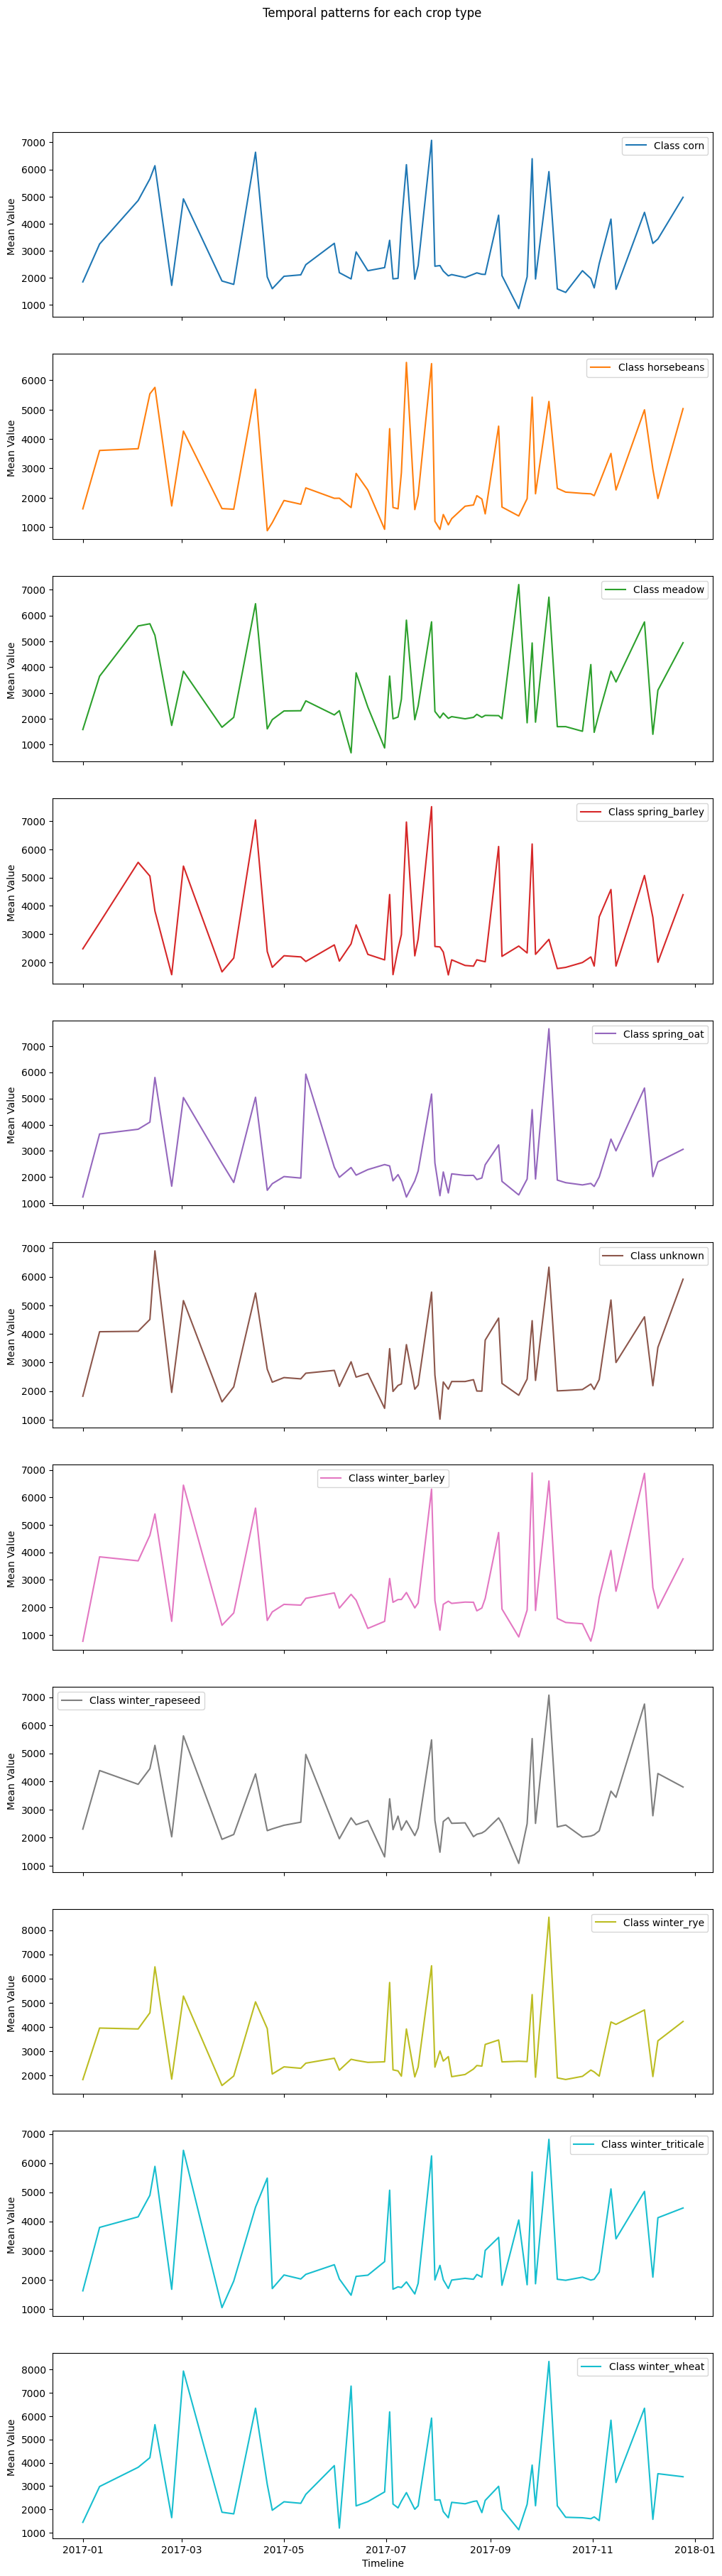

In [ ]:
#mean for each crop types across the timeline
class_means = {}
for class_name in np.unique(class_names_filtered):
    class_indices = np.where(class_names_filtered == class_name)[0]
    class_data = series[class_indices]
    mean_across_time = np.mean(class_data, axis=(0, 2))  # Calculate mean across time and channels
    class_means[class_name] = mean_across_time

# Plot the mean for each class in separate subplots with different colors
num_classes = len(class_means)
fig, axes = plt.subplots(num_classes, 1, figsize=(12, 4 * num_classes), sharex=True)

# Define a set of distinct colors for each class
colors = plt.get_cmap('tab10', num_classes)

for i, (class_name, mean_across_time) in enumerate(class_means.items()):
    color = colors(i)
    axes[i].plot(dates, mean_across_time, color=color, label=f'Class {class_name}')
    axes[i].set_ylabel('Mean Value ')

    axes[i].legend()

plt.xlabel('Timeline')
plt.suptitle('Temporal patterns for each crop type', y=0.92)

plt.show()



The mean reflectance plots above show distinct and subtle fluctuations over time which would be an indication of variations in vegetation growth or phenological changes for different crop types. The classifiers should ideally use these patterns to determine the time series class.

#Data preparation

##Custom dataset

Dataloaders : torch Dataloader takes a torch Dataset as input, and calls the __getitem__() function from the Dataset class to create a batch of data.

This class organizes the time series data into suitable formats, allowing for customizable transform parameters depending on the specific preprocessing needed.

For one method employed, flattening and normalization is applied while in another, only normalization is required. Normalization was applied to stabilize training and improve convergence.

In [ ]:
class TimeSeriesDataset(Dataset):

  def __init__(self, x, y,transform=None):
    self.x=x
    self.y=y
    self.transform=transform  #optional transforms



  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):

    features=self.x[idx]
    target=self.y[idx]

    if self.transform:
        features=self.transform(features)

    #Convert to tensors
    features=torch.tensor(features,dtype=torch.float32)
    target=torch.tensor(target,dtype=torch.long)


    return features,target

##transforms

Custom min_max normalization

Common standardization techniques like z_normalization are not appropriate for vegetation mapping as they do not capture the significance of NDVI magnitudes which is essential in mapping. The traditional min0max normalization on the other hand is sensitive to extreme values. As a result, rather than the max and min, we substitute with the 2% and 98 % percentile instead. Pelletier et al,(2019)

In [ ]:
#transforms
class FlattenTransform(): #to flatten the 3D array into a 2D array
    def __call__(self, sample):

      sample= sample.reshape(sample.shape[0]*sample.shape[1])
      return sample


class NormalizeTransform(): #a custom normalization that uses the 2nd and 98th percentile as min and max values respectively
    def __init__(self, min, max):
        self.min = min
        self.max = max

    def __call__(self, sample):

        sample=(sample - self.min) / (self.max-self.min)
        return sample


class Transpose():# to change the shape (m,d,l) where m is the number of time series in a given domain,
## l is the length of the time series, and d is the number of channels in the image
  def __call__(self,sample):
    sample=sample.transpose(1,0)
    return sample


## Data Splitting for Training and Testing

In our dataset, we aim to ensure that each class is well-represented in the training, validation and testing datasets. To achieve this, we will use the `StratifiedShuffleSplit` method from scikit-learn with the following split ratios:

- **Training Set**: 85%
- **Validation Set**: 7.5%
- **Testing Set**: 7.5%



In [ ]:
#initial split of the data for computing min and max values
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed, shuffle=True,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed, shuffle=True,stratify=y_train)




In [ ]:
#compute min and max values to be used in normalization
min_per=np.percentile(X_train,2,axis=0)
max_per=np.percentile(X_train,98,axis=0)

The distribution of classes in the split data

In [ ]:
#class distribution in the data splits
counts_train = label_count(y_train, 'Train')
counts_val = label_count(y_val, 'Val')
counts_test = label_count(y_test, 'Test')

# Merge the counts into a single table
merged_counts = pd.merge(counts_train, counts_val, on='Class', how='outer')
merged_counts = pd.merge(merged_counts, counts_test, on='Class', how='outer')

# Print the table
print(merged_counts)

    Class  Count_Train  Count_Val  Count_Test
0       0         7323       1292        1520
1       1          332         59          69
2       2        13171       2325        2735
3       3          208         37          43
4       4          425         75          88
5       5         3721        656         773
6       6         3345        590         694
7       7          741        131         154
8       8          423         75          88
9       9         1067        188         221
10     10         4616        815         959


Meadow has a significantly large representation

# Multilayer Perceptron

## Load the data
Apply the normalization and flattening transforms on the data



In [ ]:
feature_transform = transforms.Compose([NormalizeTransform(min_per,max_per),FlattenTransform()])
train_dataset=TimeSeriesDataset(X_train,y_train,transform=feature_transform)
val_dataset=TimeSeriesDataset(X_train,y_train,transform=feature_transform)
test_dataset=TimeSeriesDataset(X_train,y_train,transform=feature_transform)

## Training,evaluation and plotting functions



In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    model.train()

    for i, batch in enumerate(dataloader):
        x_train, y_train_batch = [t.to(device) for t in batch]

        # Forward pass
        y_hat = model(x_train)

        # Compute the loss
        loss = loss_fn(y_hat, y_train_batch)
        train_loss += loss.item()

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Count correct predictions
        _, predicted = torch.max(y_hat, 1)
        correct_predictions += (predicted == y_train_batch).sum().item()
        total_samples += y_train_batch.size(0)

    # Calculate accuracy and average loss
    accuracy = correct_predictions / total_samples
    average_loss = train_loss / len(dataloader)

    return average_loss, accuracy

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x_val_batch, y_val_batch in dataloader:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)

            y_val_hat = model(x_val_batch)

            loss = loss_fn(y_val_hat, y_val_batch)
            test_loss += loss.item()

            _, predicted = torch.max(y_val_hat, 1)
            correct_predictions += (predicted == y_val_batch).sum().item()
            total_samples += y_val_batch.size(0)

    # Calculate accuracy and average loss
    accuracy = correct_predictions / total_samples
    average_loss = test_loss / len(dataloader)

    return average_loss, accuracy

def plot_metrics(train_loss, train_accuracy, val_loss, val_accuracy):
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Architecture
This neural network(Multilayer Perceptron) consists of fully connected linear layers with ReLU activation functions and a dropout layer for regularization as summarized on the table below

| Layer Name        | Type                    | Purpose                                            | Configuration                                                |
|-------------------|-------------------------|----------------------------------------------------|--------------------------------------------------------------|
| Input Layer (fcin)| Linear Layer (nn.Linear)| Processes input features                           | Input size: in_size, Output size: hidden_units[0]             |
| Hidden Layers (fcs)| Sequential Container    | Groups hidden layers and activation functions      | For each hidden layer (except the last one) in hidden_units:  |
|                   |                         |                                                    |   - Linear Layer (nn.Linear): Input size from previous layer, Output size from hidden_units list                          |
|                   |                         |                                                    |   - ReLU Activation (nn.ReLU)                                  |
|                   |                         |                                                    |   - Dropout Layer (nn.Dropout): Dropout probability of dropout_prob (default: 0.5) for regularization(left out as an option for testing purposes)                       |
| Output Layer (fcout)| Linear Layer (nn.Linear)| Produces final output of the network                | Input size: hidden_units[-1] (output size of last hidden layer), Output size: out_size (number of classes)     

 Summary of the MLP architecture               |


In [ ]:
import torch.nn as nn

class TimeMLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_units=[128, 256, 128]):
        super(TimeMLP, self).__init__()

        # Define the input layer
        self.fcin = nn.Linear(in_size, hidden_units[0])

        # Define hidden layers
        fc_modules = []
        for ii in range(len(hidden_units) - 1):
            fc_modules.append(nn.Linear(hidden_units[ii], hidden_units[ii + 1]))

            fc_modules.append(nn.ReLU())
            #fc_modules.append(nn.Dropout(p=dropout_prob))  # Dropout layer added
        self.fcs = nn.Sequential(*fc_modules)

        # Define the output layer
        self.fcout = nn.Linear(hidden_units[-1], out_size)

    def forward(self, x):
        # Input layer
        x = self.fcin(x)
        x = nn.functional.relu(x)

        # Hidden layers
        x = self.fcs(x)

        # Output layer
        logits = self.fcout(x)
        return logits


In [ ]:
#initialize the model
num_classes=len(class_names_filtered)
MLPModel=TimeMLP(580,num_classes,hidden_units=[256,256]).to(device)


In [ ]:
# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MLPModel.parameters(),lr=0.01,amsgrad=True)

## Model training

In [ ]:
#Encapsulate the training,evaluation and plotting into a function

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=80):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n------------------------------")

        # Training
        train_loss, train_accuracy = train_loop(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

        # Validation
        val_loss, val_accuracy = test_loop(val_loader, model, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Plotting
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)




Epoch 1
------------------------------
Training Loss: 0.5493, Training Accuracy: 0.8288
Validation Loss: 0.3029, Validation Accuracy: 0.9045
Epoch 2
------------------------------
Training Loss: 0.3176, Training Accuracy: 0.9000
Validation Loss: 0.2871, Validation Accuracy: 0.9095
Epoch 3
------------------------------
Training Loss: 0.2888, Training Accuracy: 0.9072
Validation Loss: 0.2840, Validation Accuracy: 0.9099
Epoch 4
------------------------------
Training Loss: 0.2748, Training Accuracy: 0.9117
Validation Loss: 0.2551, Validation Accuracy: 0.9183
Epoch 5
------------------------------
Training Loss: 0.2627, Training Accuracy: 0.9154
Validation Loss: 0.2449, Validation Accuracy: 0.9163
Epoch 6
------------------------------
Training Loss: 0.2457, Training Accuracy: 0.9208
Validation Loss: 0.2294, Validation Accuracy: 0.9255
Epoch 7
------------------------------
Training Loss: 0.2449, Training Accuracy: 0.9199
Validation Loss: 0.2148, Validation Accuracy: 0.9284
Epoch 8
-----

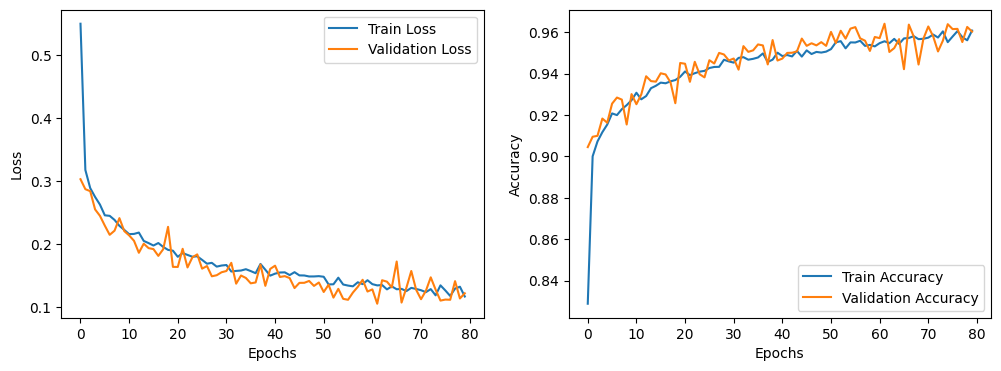

Total training time: 212.567 seconds


In [ ]:
torch.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
#dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

start_time = timer()
train_and_evaluate(MLPModel, train_loader, val_loader, criterion, optimizer, epochs=80)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

The plots above show how loss and accuracy progresses as the model is trained. The validation loss and accuracy exhibit fluctuations which could indicate that the training process is unstable. However, the validation accuracy is quite high. Therefore, it may be necessary to tune learning rate(which might be causing the model to oscillate) as well as batch size

In [ ]:
# Evaluate the model on test data
def test_model(model, test_loader, criterion, device):
    test_losses = []
    correct = 0
    total = 0
    y_pred=[]
    y_true =[]

    model.eval()

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        y_test_hat = model(inputs)


        test_loss = criterion(y_test_hat, labels)
        test_losses.append(test_loss.item())

        y_test_hat_class = (torch.max(torch.exp(y_test_hat), 1)[1]).data.cpu().numpy()
        y_pred.extend(y_test_hat_class)

        labels_np = labels.data.cpu().numpy()
        y_true.extend(labels_np)

        total += labels.size(0)
        correct += (y_test_hat_class == labels_np).sum().item()

    test_loss_mean = np.mean(test_losses)
    test_accuracy = correct / len(test_loader.dataset)

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names_filtered],
                     columns = [i for i in class_names_filtered])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    #plt.savefig('output.png')

    return test_loss_mean, test_accuracy




Test loss: 0.122
Test accuracy: 96.028%


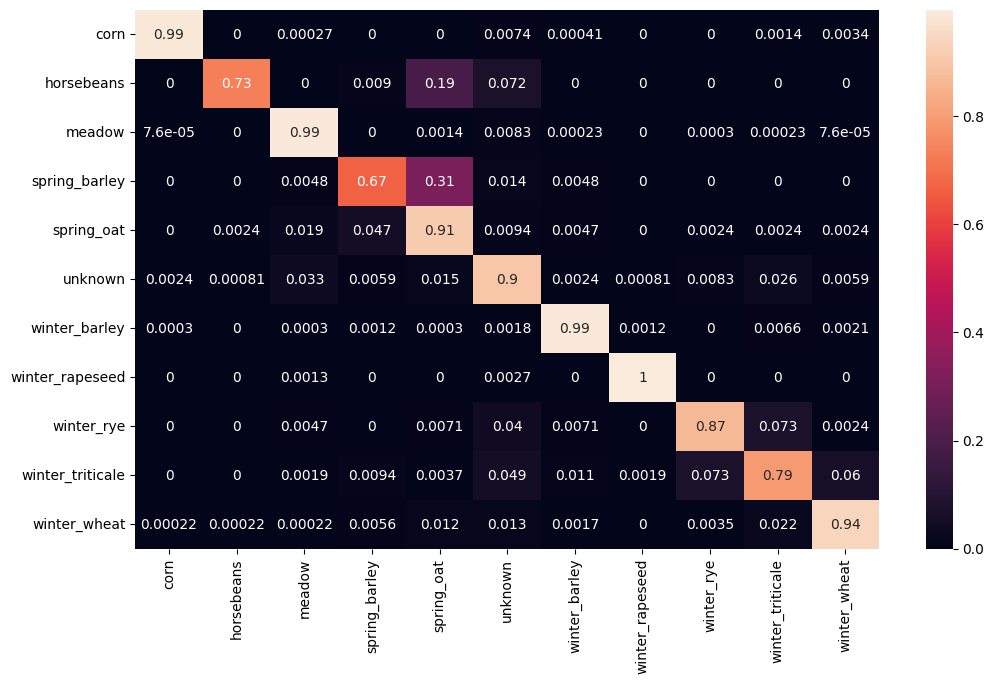

In [ ]:
torch.manual_seed(seed)
test_loss, test_acc = test_model(MLPModel, test_loader, criterion, device)

print("Test loss: {:.3f}".format(test_loss))
print("Test accuracy: {:.3f}%".format(test_acc * 100))

## Hyperarameter tuning


In [ ]:

def hyper_tune(lr, bs):
    torch.manual_seed(seed)
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

    model=TimeMLP(580,num_classes,hidden_units=[256,256]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(MLPModel.parameters(),lr=lr,amsgrad=True)


    epochs = 80
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    torch.manual_seed(42)
    for epoch in range(epochs):
        #print(f"Epoch {epoch + 1}\n-------------------------------")

        # Training
        train_loss, train_accuracy = train_loop(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        #print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

        # Validation
        val_loss, val_accuracy = test_loop(val_loader, model, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        #print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    torch.save(model.state_dict(), "model_weights.pth")
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

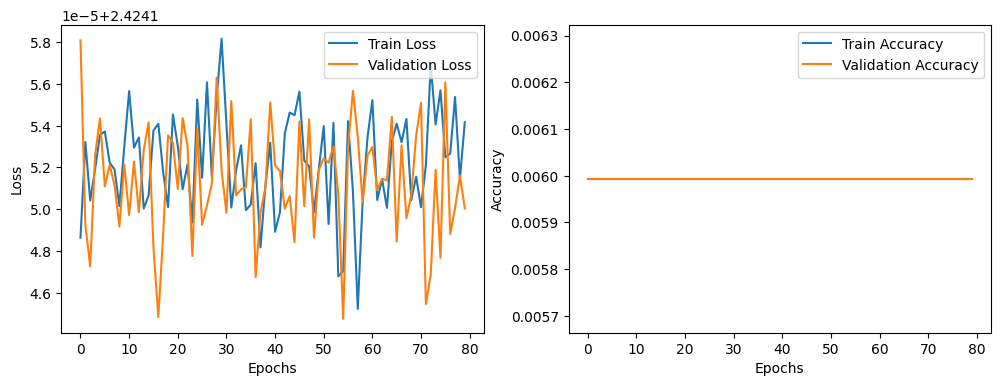

In [ ]:
torch.manual_seed(seed)
hyper_tune(lr=0.0001,bs=64)

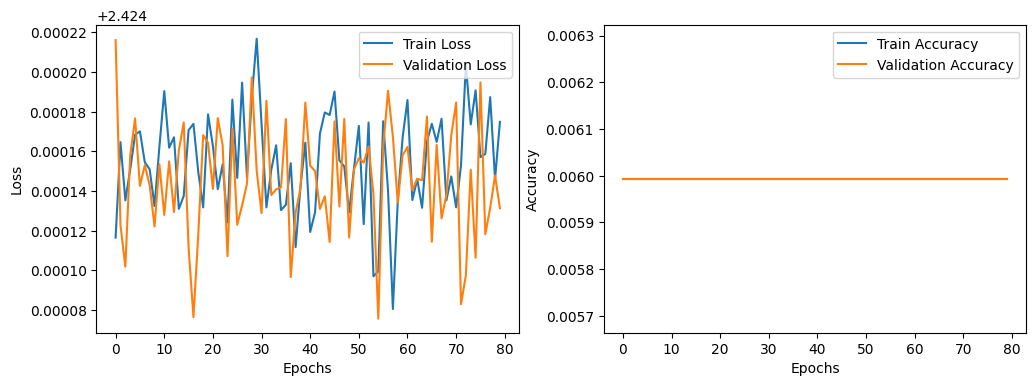

In [ ]:
torch.manual_seed(seed)
hyper_tune(lr=0.001,bs=256)

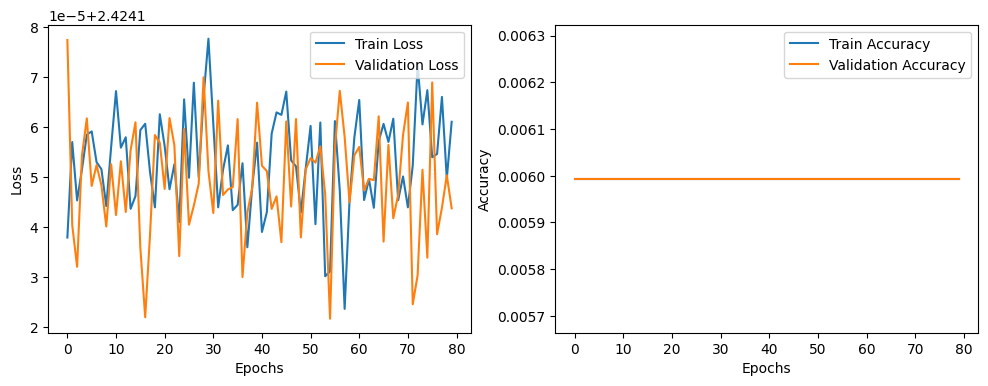

In [ ]:
torch.manual_seed(seed)
hyper_tune(lr=0.1,bs=128)

## Final training with the optimal parameters

In [ ]:
num_classes=len(class_names_filtered)
MLPModelFin=TimeMLP(580,num_classes,hidden_units=[256,256]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MLPModelFin.parameters(),lr=0.0001,amsgrad=True)

Epoch 1
------------------------------
Training Loss: 1.5081, Training Accuracy: 0.5358
Validation Loss: 0.9336, Validation Accuracy: 0.7050
Epoch 2
------------------------------
Training Loss: 0.7852, Training Accuracy: 0.7486
Validation Loss: 0.6705, Validation Accuracy: 0.7826
Epoch 3
------------------------------
Training Loss: 0.6098, Training Accuracy: 0.8086
Validation Loss: 0.5460, Validation Accuracy: 0.8295
Epoch 4
------------------------------
Training Loss: 0.5101, Training Accuracy: 0.8427
Validation Loss: 0.4637, Validation Accuracy: 0.8651
Epoch 5
------------------------------
Training Loss: 0.4470, Training Accuracy: 0.8654
Validation Loss: 0.4118, Validation Accuracy: 0.8797
Epoch 6
------------------------------
Training Loss: 0.4069, Training Accuracy: 0.8808
Validation Loss: 0.3794, Validation Accuracy: 0.8875
Epoch 7
------------------------------
Training Loss: 0.3807, Training Accuracy: 0.8885
Validation Loss: 0.3638, Validation Accuracy: 0.8954
Epoch 8
-----

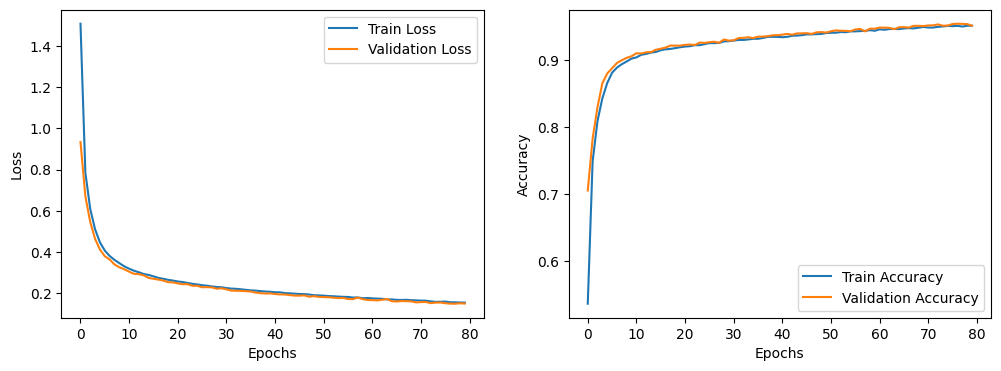

Total training time: 224.710 seconds


In [ ]:
torch.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)
#dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

start_time = timer()
train_and_evaluate(MLPModelFin, train_loader, val_loader, criterion, optimizer, epochs=80)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Test loss: 0.150
Test accuracy: 95.106%


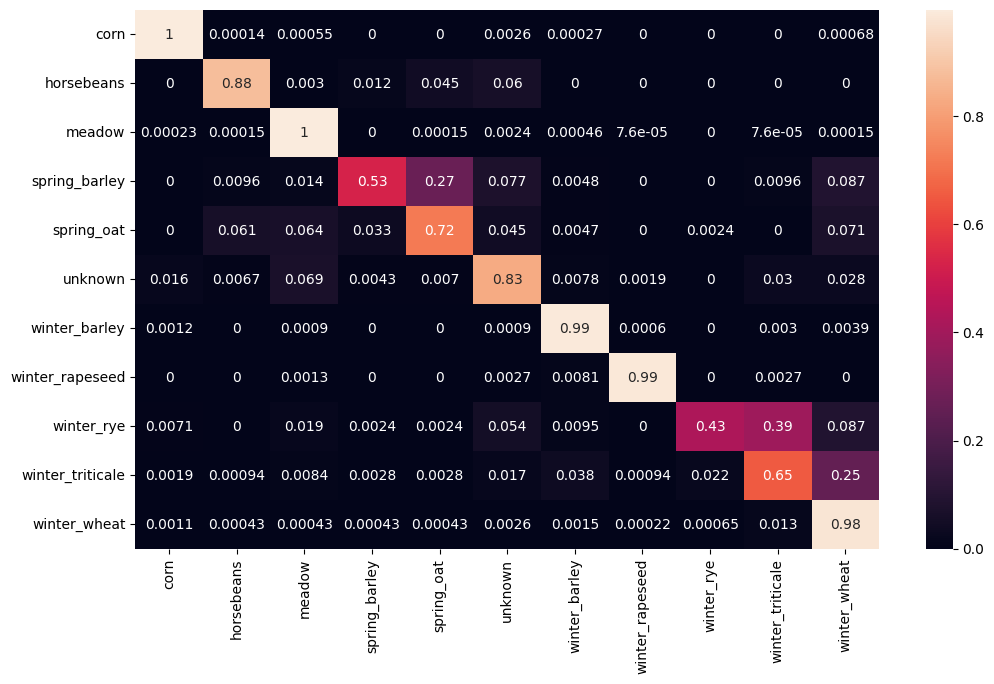

In [ ]:
torch.manual_seed(seed)
test_loss, test_acc = test_model(MLPModelFin, test_loader, criterion, device)

print("Test loss: {:.3f}".format(test_loss))
print("Test accuracy: {:.3f}%".format(test_acc * 100))

# 1-D Convolutional neural network
CNNs have demonstrated remarkable success in various remote sensing tasks, showcasing their efficacy in tasks such as land cover classification, semantic segmentation, object detection, and more. In remote sensing, CNNs are often applied to exploit spatial,temporal and spectral dimensions by performing convolutions in both the x and y dimensions.

With 1D CNNs,kernels slide along one dimension( the temporal dimension which also has spatial patterns) hence suitable for time series. The convolutional layer outputs a new time series in the case of a univariate time series like we have.


The data input shape is crucial when working with 1D convolutions
For a 1D CNN, the data input format should be in the following shape: (batch_size, num_channels, sequence_length).



*   Batch Size (batch_size): The number of samples in each batch.
*   Number of Channels (num_channels): The channels typically represent different bands or features
* Sequence Length (sequence_length): represents the temporal dimension

| Layer Name        | Type                    | Purpose                                            | Configuration                                                |
|-------------------|-------------------------|----------------------------------------------------|--------------------------------------------------------------|
| Conv1 (conv1)     | Conv1d (nn.Conv1d)      | Convolutional layer for initial feature extraction  | Input channels: num_channels, Output channels: 32, Kernel size: 3 |
| ReLU (relu)       | ReLU (nn.ReLU)          | Introduces non-linearity after the first convolution | -                                                            |
| MaxPool1d (pool)  | MaxPool1d (nn.MaxPool1d)| Max pooling layer for downsampling                  | Kernel size: 2                                               |
| Conv2 (conv2)     | Conv1d (nn.Conv1d)      | Convolutional layer for further feature extraction  | Input channels: 32, Output channels: 64, Kernel size: 3        |
| ReLU (relu)       | ReLU (nn.ReLU)          | Introduces non-linearity after the second convolution| -                                                           |
| MaxPool1d (pool)  | MaxPool1d (nn.MaxPool1d)| Max pooling layer for downsampling                  | Kernel size: 2                                               |
| Flatten (flatten) | Flatten (nn.Flatten)    | Flatten the output for transition to fully connected layers | -                                                    |
| FC1 (fc1)         | Linear (nn.Linear)      | Fully connected layer for feature transformation    | Input size: 64 * 13, Output size: 128                          |
| ReLU (relu)       | ReLU (nn.ReLU)          | Introduces non-linearity after the first fully connected layer| -                                                  |
| Dropout (dropout) | Dropout (nn.Dropout)    | Dropout layer for regularization                    | Dropout probability: 0.5                                    |
| FC2 (fc2)         | Linear (nn.Linear)      | Fully connected layer for final output               | Input size: 128, Output size: num_classes + 1                 |

Summary of the 1D CNN architecture


### Load the data

In [ ]:
feature_transform = transforms.Compose([NormalizeTransform(min_per,max_per),Transpose()])
train_dataset=TimeSeriesDataset(X_train,y_train,transform=feature_transform)
val_dataset=TimeSeriesDataset(X_train,y_train,transform=feature_transform)
test_dataset=TimeSeriesDataset(X_train,y_train,transform=feature_transform)

### Architecture

In [ ]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [ ]:
#Initial tests to understand how the architecture works
m = nn.Conv1d(32, 64, 3)
relu=nn.ReLU()
pool=nn.MaxPool1d(kernel_size=2)
input = torch.randn(31442,32 ,28)
output1 = m(input)
output2=relu(output1)
output3=pool(output2)
output4=output3.view(output3.size(0), -1)
linear1=nn.Linear(64*13, 128)
linear2=nn.Linear(128, num_classes)
output5=linear1(output4)
output6=linear2(output5)

print(output3.shape,output4.shape,output5.shape,output6.shape)

torch.Size([31442, 64, 13]) torch.Size([31442, 832]) torch.Size([31442, 128]) torch.Size([31442, 11])


Now put these together in a class

In [ ]:
import torch.nn as nn

class Conv1DCrop(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(Conv1DCrop, self).__init__()

        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=3)
        #self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        #self.bn2 = nn.BatchNorm1d(64)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 13, 128)
        #self.bn_fc1 = nn.BatchNorm1d(128)

        self.dropout = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, num_classes + 1)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        #x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        #x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x


In [ ]:
num_channels = 10  # 10 bands
num_classes=len(class_names_filtered)
ConvClassifier=Conv1DCrop(num_channels,num_classes).to(device)

In [ ]:
# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvClassifier.parameters(),lr=0.001,amsgrad=True)

## Model training

Epoch 1
------------------------------
Training Loss: 0.7830, Training Accuracy: 0.7504
Validation Loss: 0.3883, Validation Accuracy: 0.8769
Epoch 2
------------------------------
Training Loss: 0.3830, Training Accuracy: 0.8837
Validation Loss: 0.3077, Validation Accuracy: 0.9036
Epoch 3
------------------------------
Training Loss: 0.3201, Training Accuracy: 0.9029
Validation Loss: 0.2732, Validation Accuracy: 0.9130
Epoch 4
------------------------------
Training Loss: 0.2791, Training Accuracy: 0.9144
Validation Loss: 0.2414, Validation Accuracy: 0.9249
Epoch 5
------------------------------
Training Loss: 0.2573, Training Accuracy: 0.9205
Validation Loss: 0.2206, Validation Accuracy: 0.9303
Epoch 6
------------------------------
Training Loss: 0.2402, Training Accuracy: 0.9263
Validation Loss: 0.1998, Validation Accuracy: 0.9375
Epoch 7
------------------------------
Training Loss: 0.2290, Training Accuracy: 0.9286
Validation Loss: 0.1952, Validation Accuracy: 0.9379
Epoch 8
-----

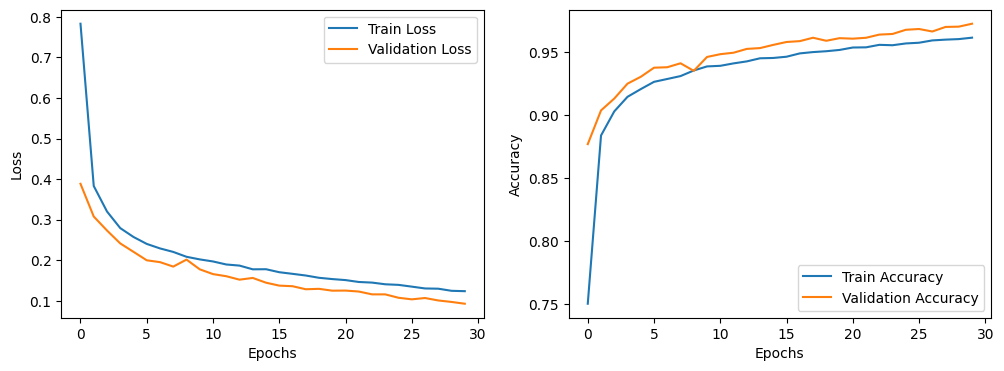

Total training time: 103.536 seconds


In [ ]:
torch.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
#dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

start_time = timer()
train_and_evaluate(ConvClassifier, train_loader, val_loader, criterion, optimizer, epochs=30)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Test loss: 0.093
Test accuracy: 97.235%


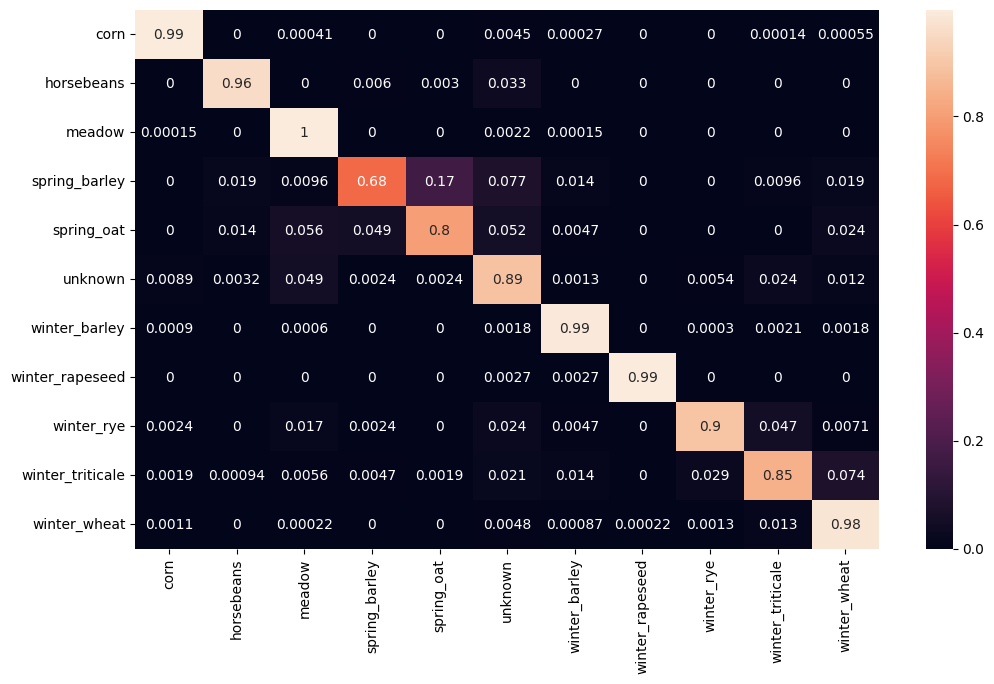

In [ ]:
torch.manual_seed(seed)
test_loss, test_acc = test_model(ConvClassifier, test_loader, criterion, device)

print("Test loss: {:.3f}".format(test_loss))
print("Test accuracy: {:.3f}%".format(test_acc * 100))


Similarly as the confusion matrix above shows, 1D Convolution also performs quite well in predicting the correct crop type with a slightly lower accuracy for the crop types with smaller sample sizes.

## Hyperparameter tuning

Manual search

In [ ]:
# Hyperparameters
torch.manual_seed(seed)
learning_rate = [0.001, 0.0001, 0.01]
batch_size = [128,256,64]
num_epochs = [50, 100, 200]

best_accuracy = 0.0
best_params = {}

for lr in learning_rate:
  for bs in batch_size:
    for ne in num_epochs:

      #create data loaders with current batch_size
      train_loader=DataLoader(train_dataset,batch_size=bs,shuffle=False)
      val_loader=DataLoader(val_dataset,batch_size=bs,shuffle=False)
      test_loader=DataLoader(test_dataset,batch_size=bs,shuffle=False)

      #Initialize the model, loss function and optimizer with current learning rate
      model=ConvClassifier=Conv1DCrop(num_channels,num_classes).to(device)
      criterion=nn.CrossEntropyLoss()
      optimizer=torch.optim.Adam(ConvClassifier.parameters(),lr=lr,amsgrad=True)

      #train and evaluate model
      for t in range(ne):
        print(f"Epoch {t + 1}\n-------------------------------")
        training_loss_history = train_loop(train_loader, ConvClassifier, criterion, optimizer)
        test_acc_history = test_loop(val_loader, ConvClassifier, criterion)

        # Print or log training loss
        print(f'Training Loss: {training_loss_history[-1]:.4f}')

        # Track the best hyperparameters based on validation accuracy
      if test_acc_history[-1] > best_accuracy:
        best_accuracy = test_acc_history[-1]
        best_params = {'Learning Rate': lr, 'Batch Size': bs, 'Num Epochs': ne}

print(f"\nBest Hyperparameters:\n{best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Epoch 1
-------------------------------
Training Loss: 0.7438
Epoch 2
-------------------------------
Training Loss: 0.8851
Epoch 3
-------------------------------
Training Loss: 0.9067
Epoch 4
-------------------------------
Training Loss: 0.9145
Epoch 5
-------------------------------
Training Loss: 0.9204
Epoch 6
-------------------------------
Training Loss: 0.9262
Epoch 7
-------------------------------
Training Loss: 0.9300
Epoch 8
-------------------------------
Training Loss: 0.9330
Epoch 9
-------------------------------
Training Loss: 0.9357
Epoch 10
-------------------------------
Training Loss: 0.9378
Epoch 11
-------------------------------
Training Loss: 0.9397
Epoch 12
-------------------------------
Training Loss: 0.9425
Epoch 13
-------------------------------
Training Loss: 0.9445
Epoch 14
-------------------------------
Training Loss: 0.9463
Epoch 15
-------------------------------
Training Loss: 0.9463
Epoch 16
-------------------------------
Training Loss: 0.9489
E

## Final training with optimal parameters

In [ ]:
um_classes=len(class_names_filtered)
num_channels=10
ConvClassifier=Conv1DCrop(num_channels,num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvClassifier.parameters(),lr=0.001,amsgrad=True)

Epoch 1
------------------------------
Training Loss: 0.6331, Training Accuracy: 0.8041
Validation Loss: 0.3419, Validation Accuracy: 0.8914
Epoch 2
------------------------------
Training Loss: 0.3454, Training Accuracy: 0.8952
Validation Loss: 0.2749, Validation Accuracy: 0.9126
Epoch 3
------------------------------
Training Loss: 0.2893, Training Accuracy: 0.9111
Validation Loss: 0.2526, Validation Accuracy: 0.9221
Epoch 4
------------------------------
Training Loss: 0.2609, Training Accuracy: 0.9195
Validation Loss: 0.2263, Validation Accuracy: 0.9313
Epoch 5
------------------------------
Training Loss: 0.2393, Training Accuracy: 0.9244
Validation Loss: 0.2024, Validation Accuracy: 0.9367
Epoch 6
------------------------------
Training Loss: 0.2278, Training Accuracy: 0.9296
Validation Loss: 0.1970, Validation Accuracy: 0.9366
Epoch 7
------------------------------
Training Loss: 0.2178, Training Accuracy: 0.9328
Validation Loss: 0.1811, Validation Accuracy: 0.9424
Epoch 8
-----

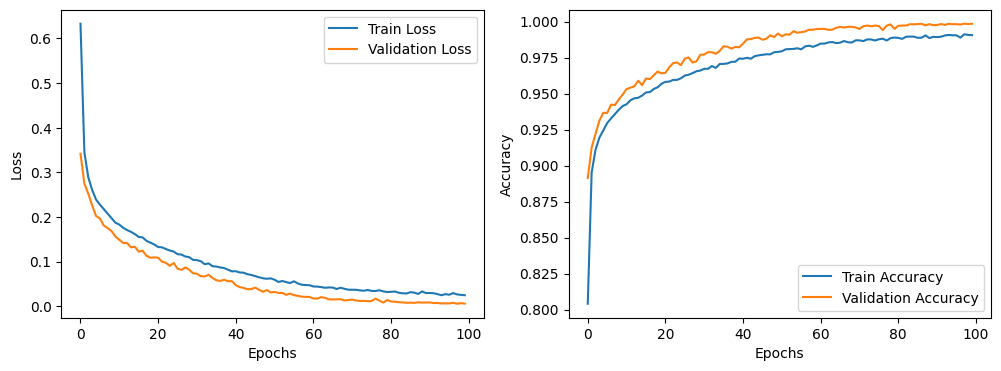

Total training time: 457.952 seconds


In [ ]:
torch.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

start_time = timer()

train_and_evaluate(ConvClassifier, train_loader, val_loader, criterion, optimizer, epochs=100)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Test loss: 0.006
Test accuracy: 99.853%


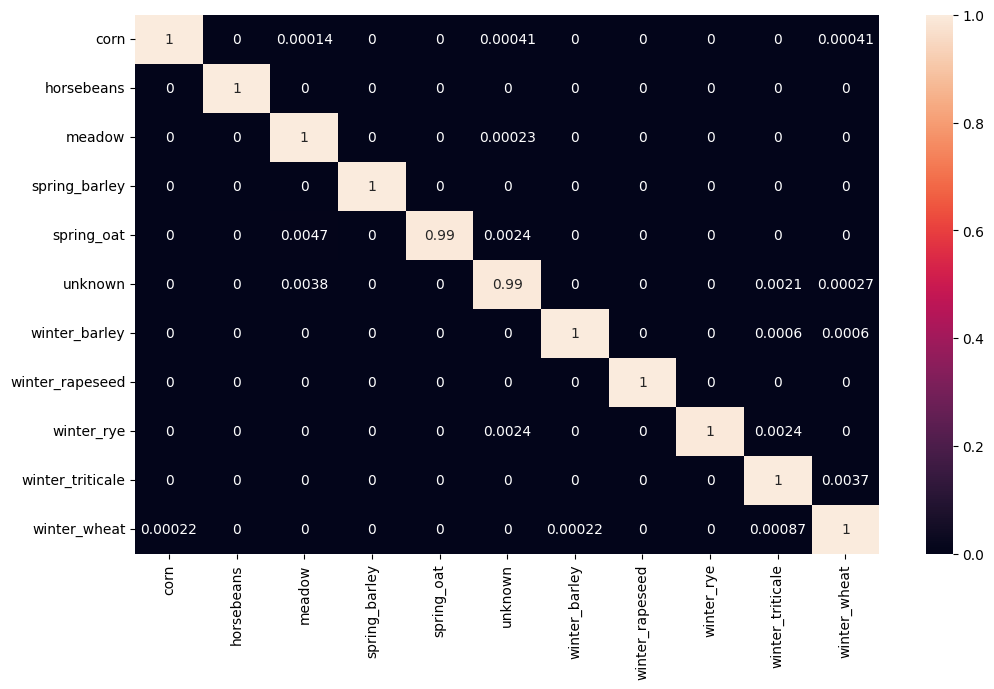

In [ ]:
torch.manual_seed(seed)
test_loss, test_acc = test_model(ConvClassifier, test_loader, criterion, device)

print("Test loss: {:.3f}".format(test_loss))
print("Test accuracy: {:.3f}%".format(test_acc * 100))

# Conclusion
A few observations have been made:

In the analysis, we observed that the validation accuracy consistently surpasses the training accuracy for both models. This behavior can be attributed to the relatively small size of our dataset, with the validation and testing sets being even smaller.

### Remedial Measures

To address this issue, we made the following adjustments:

1. **Increased Epochs:**
   - We increased the number of training epochs to allow the models to better learn from the limited data.

2. **Reduced Dropout Value:**
   - Dropout is a regularization technique that helps prevent overfitting. By reducing the dropout value, we allowed the models to retain more information during training

In comparison,both models perform pretty well in predicting the crop type, however for MLP, there is a lot of instability in the model training as shown during the hyperparameter tuning process. Furthermore, with more epochs, training the 1D convolution network took a shorter time, however, the difference is not very significant.
Upon tuning the ID convolution and testing it, the performance was nearly perfect which raises further questions. As a result, a different architecture is to be considered.

# References

1. Pelletier, C., Webb, G., & Petitjean, F. (2019). Temporal Convolutional Neural Network for the Classification of Satellite Image Time Series. Remote Sensing, 11(5), 523. https://doi.org/10.3390/rs11050523

2. Painblanc, F., Chapel, L., Courty, N., Friguet, C., Pelletier, C., & Tavenard, R. (2023). Match-And-Deform: Time Series Domain Adaptation Through Optimal Transport and Temporal Alignment. In D. Koutra, C. Plant, M. Gomez Rodriguez, E. Baralis, & F. Bonchi (Eds.), Machine Learning and Knowledge Discovery in Databases: Research Track (Vol. 14173, pp. 341–356). Springer Nature Switzerland. https://doi.org/10.1007/978-3-031-43424-2_21


3. [batch-norm-explained](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739)
